# Heart Rate Monitoring Forecast(Time-Series)


## 1. Project Explanation

 - Json File created from a recorded bout of exercise with the POLAR H10 Heart Rate monitor.
 - Main objective are to practice different techniques and models to better understand the heart rate trend in the attempt to be able to forecast in the case of lost of data.
 - Read json file
 - Exploratory Data Analysis of the dataframe.
 - Test different transformation techniques:
     - Decomposition
     - Differencing:
         - Log Scale
         - Time Shift
         - Exponential Decay         
 - Test different models:
     - AR Model
     - MA Model 
     - ARIMA Model

## 2. Import Data 

In [30]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import lag_plot
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import numpy as np
import math
import json
import csv

sns.set(style="whitegrid", color_codes=True)

In [31]:
# Import json file
with open('/Users/daviddiaz/Documents/HRV_Analysis/PolarHR.json') as json_file:
    data = json.load(json_file)

In [32]:
# Read and Edit File 
HR_data = data["exercises"]
data_file = open('HeartRate.csv', 'w')
csv_writer = csv.writer(data_file)
count = 0
for hr in HR_data:
    if count == 0:
        header = hr.keys()
        csv_writer.writerow(header)
        count += 1       
    csv_writer.writerow(hr.values())
data_file.close() 

for section in data['exercises']:
    x = section['samples']

#### Transformation to CSV is for seperate reasons than this specific project

In [33]:
df = pd.DataFrame(list(x['heartRate']))
y = pd.to_datetime(df["dateTime"])
x = df['value']
df = pd.concat([y,x], axis=1)   

In [34]:
import datetime
df = df.set_index(['dateTime'])
# Splitting data 70/30 (x_train/x_test respectively)
x_train = df[df.index <datetime.datetime(2021, 12, 9, 18, 28, 45)]
x_test = df[df.index >=datetime.datetime(2021, 12, 9, 18, 28, 45)]

## 3. Exploratory Data Analysis

In [35]:
# Refering x_train as df
df = x_train
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1736 entries, 2021-12-09 17:59:49.786000 to 2021-12-09 18:28:44.786000
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   1736 non-null   int64
dtypes: int64(1)
memory usage: 27.1 KB


This file is 27.1 KB. There are two variables (dateTime & value) with 1736 values. 

In [36]:
# Missing Value Treatment
df.isnull().sum()

value    0
dtype: int64

No missing values.

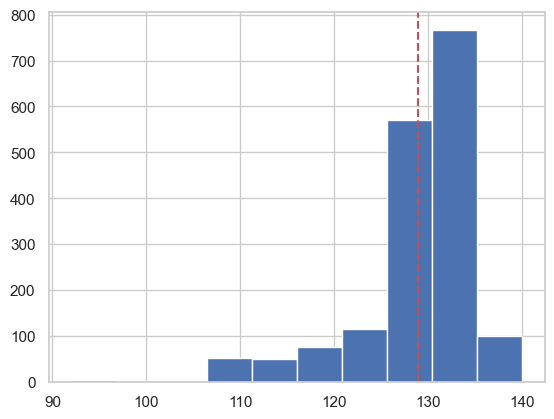

<Figure size 3000x4000 with 0 Axes>

In [37]:
# Skewness
df_skew = df.value
plt.hist(df_skew)
plt.axvline(x=np.mean(df['value']), color='r', linestyle='--', label='Mean')
plt.figure(figsize=(30,40))
plt.show()

The dataset is skewed to the left (negative skew).

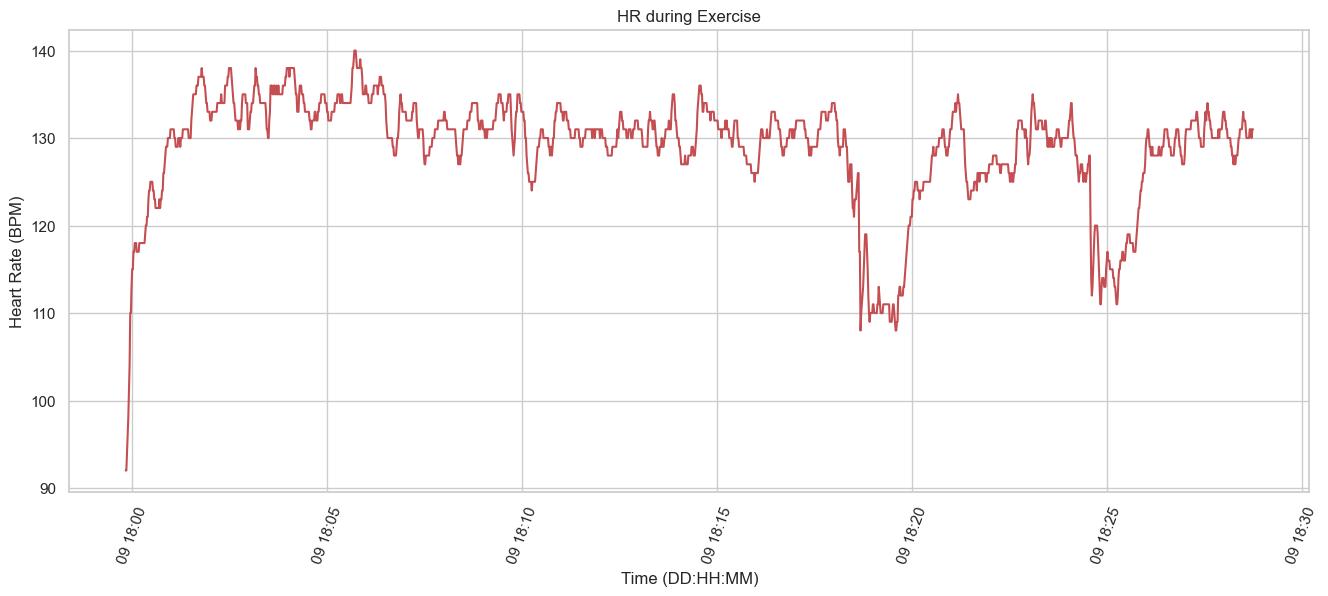

In [38]:
# Visualize dataset
sns.set(style="whitegrid", color_codes=True)

plt.figure(figsize=(16, 6))
plt.plot(df.index,df['value'], color='r')
plt.title("HR during Exercise")
plt.xticks(rotation=70)
plt.xlabel("Time (DD:HH:MM)")
plt.ylabel("Heart Rate (BPM)")
plt.show()

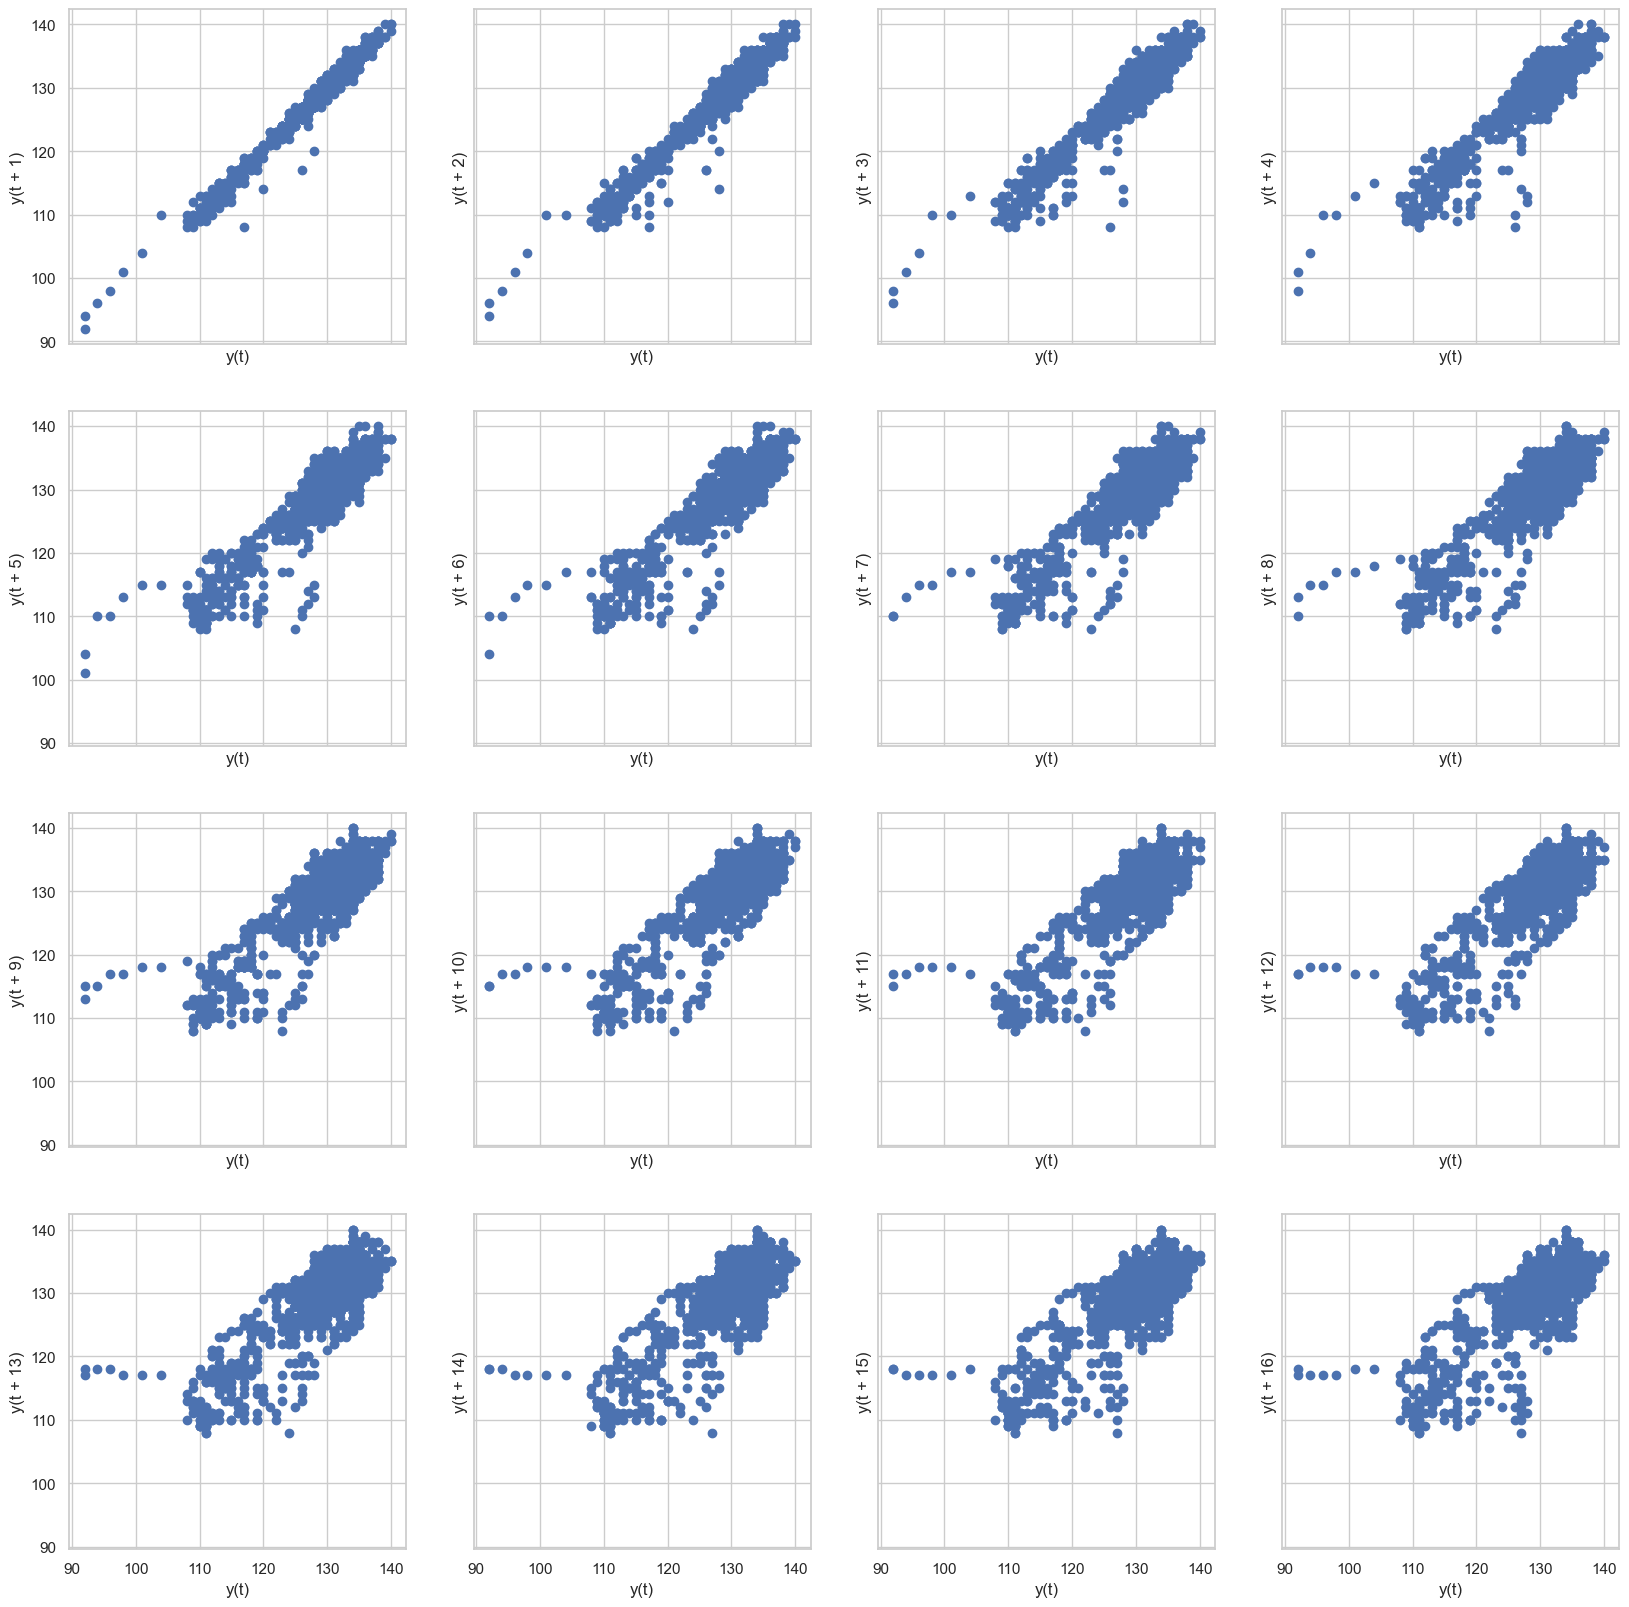

In [39]:
# Plotting 25 lag plots to determine randomness in data.
lags = 20
rows = 4
cols = 4
fig, axes = plt.subplots(rows, cols, sharex=True, sharey=True)
fig.set_figwidth(lags)
fig.set_figheight(lags)
count =1
for i in range(rows):
    for j in range(cols):
        lag_plot(df["value"], lag=count, ax=axes[i, j])
        count+=1

The intial portion of the data is indeed different from the rest, which is most likely due to it being the begining of the run and the heart rate is acclimizing and not even close to steady state. There is a quick spike of heart rate that last about 2 minutes.

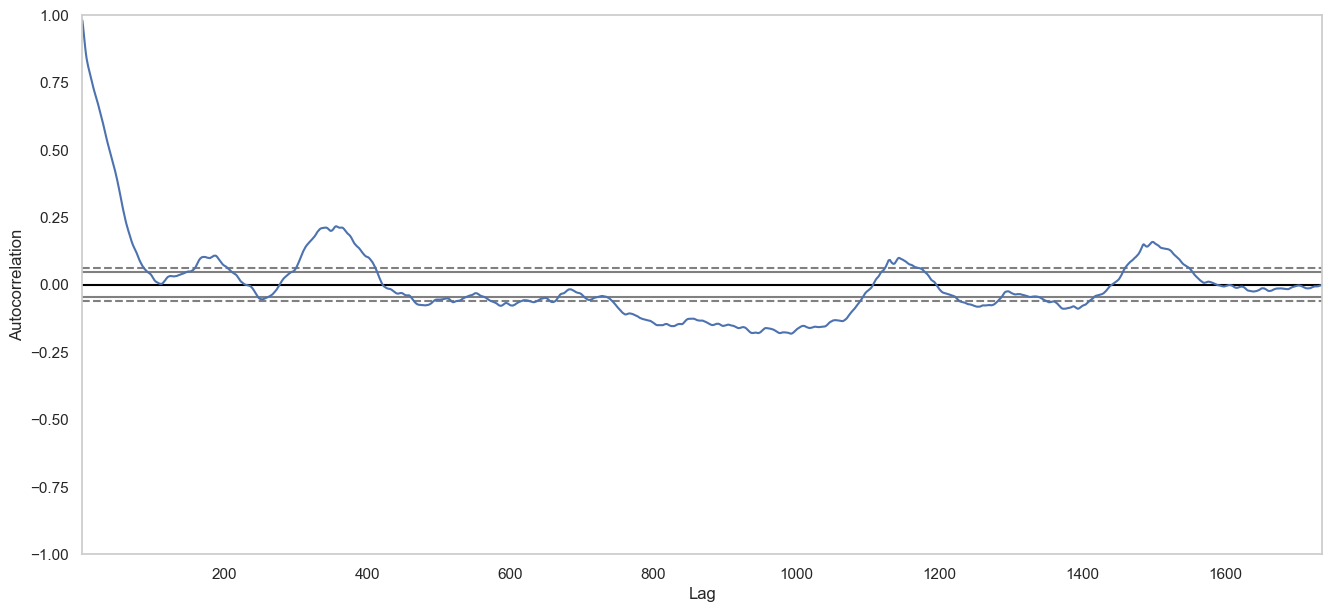

In [40]:
# Autocorrelation of dataset
plt.figure(figsize=(16, 7)) 
autocorrelation_plot(df["value"])
plt.show()

From this Autocorrelation plot, it can be infered that there is no strong correlation between the values (heartrate), therefore, it is not stationary.

In [41]:
# Stationary Test Function
def stationarity_test(data):
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Numberof Observations Used'])
    Rolling_mean = data.rolling(window=12).mean()
    Rolling_std = data.rolling(window=12).std()
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    plt.figure(figsize=(20, 7))
    plt.plot(Rolling_mean, color='red', label='Rolling Mean')
    plt.plot(Rolling_std, color='black', label='Rolling Std')
    plt.legend(fontsize=20)
    plt.plot(data.index, data)
    plt.show()

Test Statistic                  -3.465124
p-value                          0.008929
#Lags Used                      15.000000
Numberof Observations Used    1720.000000
Critical Value (1%)             -3.434158
Critical Value (5%)             -2.863222
Critical Value (10%)            -2.567665
dtype: float64


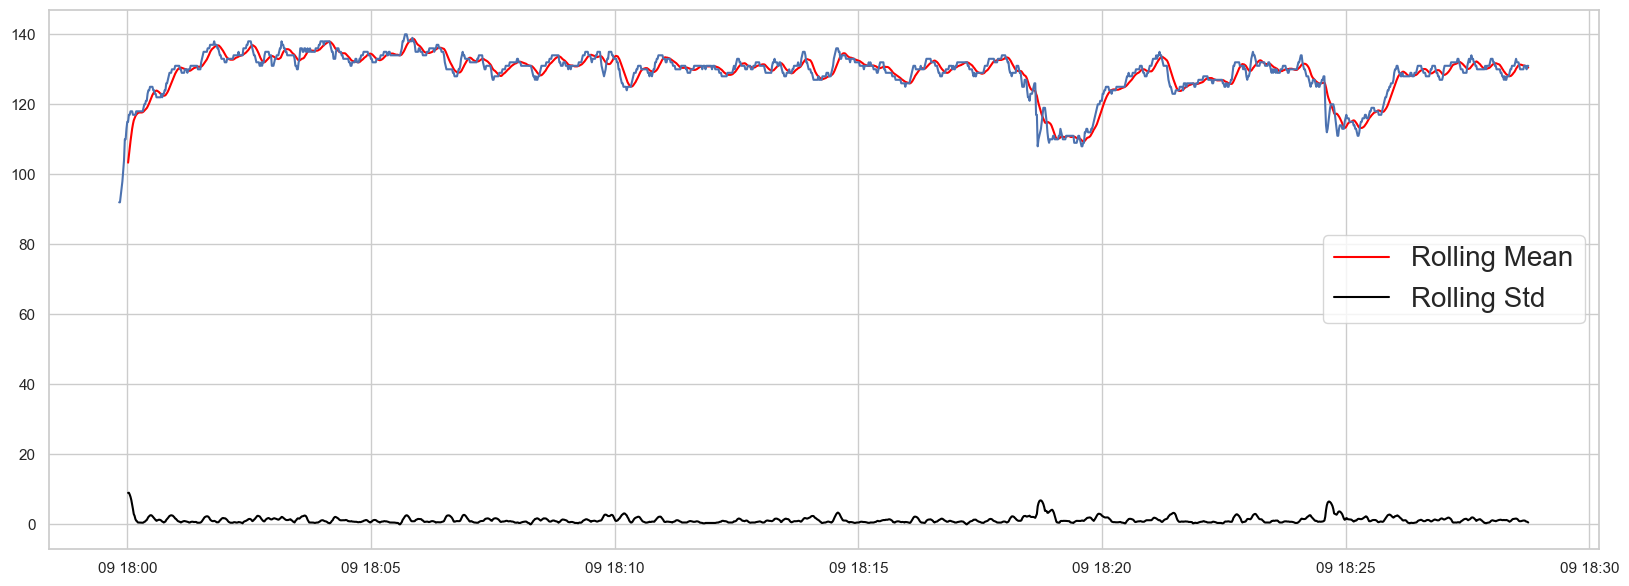

In [42]:
# Stationarity_test for original dataset to visualize rolling mean and standard deviation
stationarity_test(df)

## 4. Feature Selection

Test Statistic               -1.460703e+01
p-value                       4.079179e-27
#Lags Used                    2.500000e+01
Numberof Observations Used    1.702000e+03
Critical Value (1%)          -3.434198e+00
Critical Value (5%)          -2.863240e+00
Critical Value (10%)         -2.567675e+00
dtype: float64


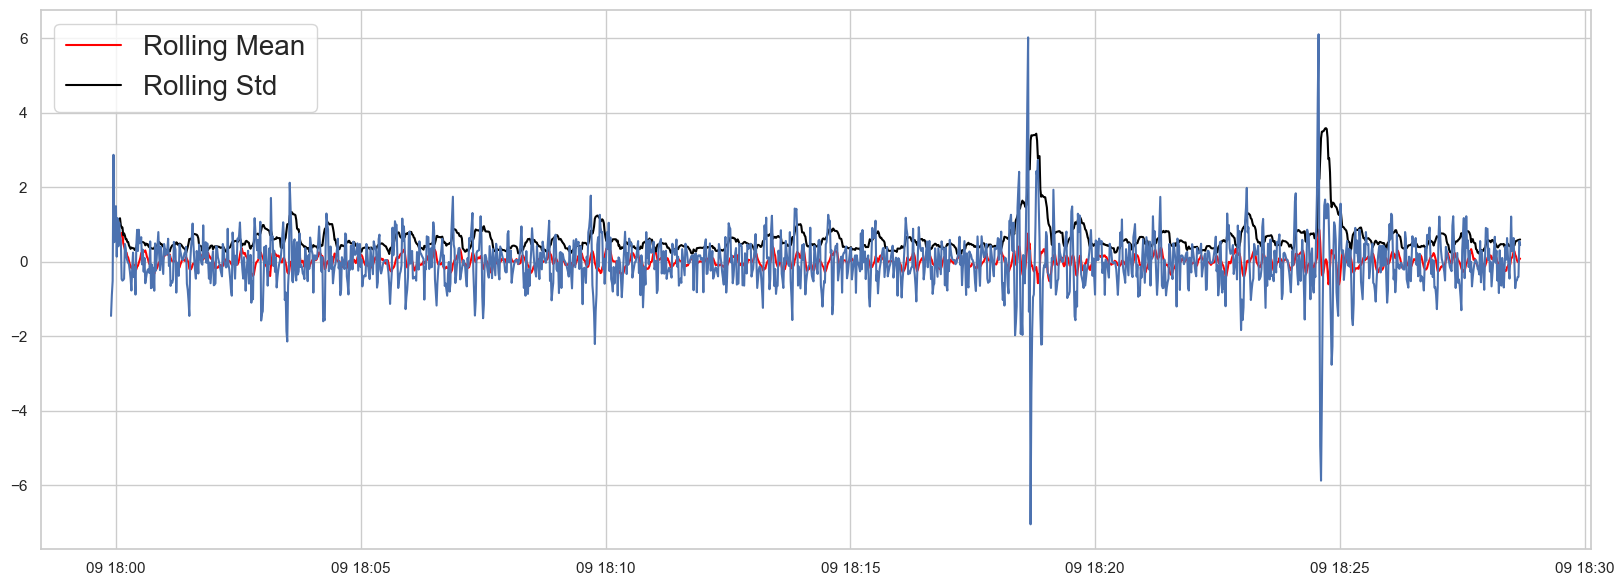

In [43]:
# Decomposition Transformation
decomposition = seasonal_decompose(df, model='additive', period=8)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

decomposeddata = residual
decomposeddata.dropna(inplace=True)
stationarity_test(decomposeddata)

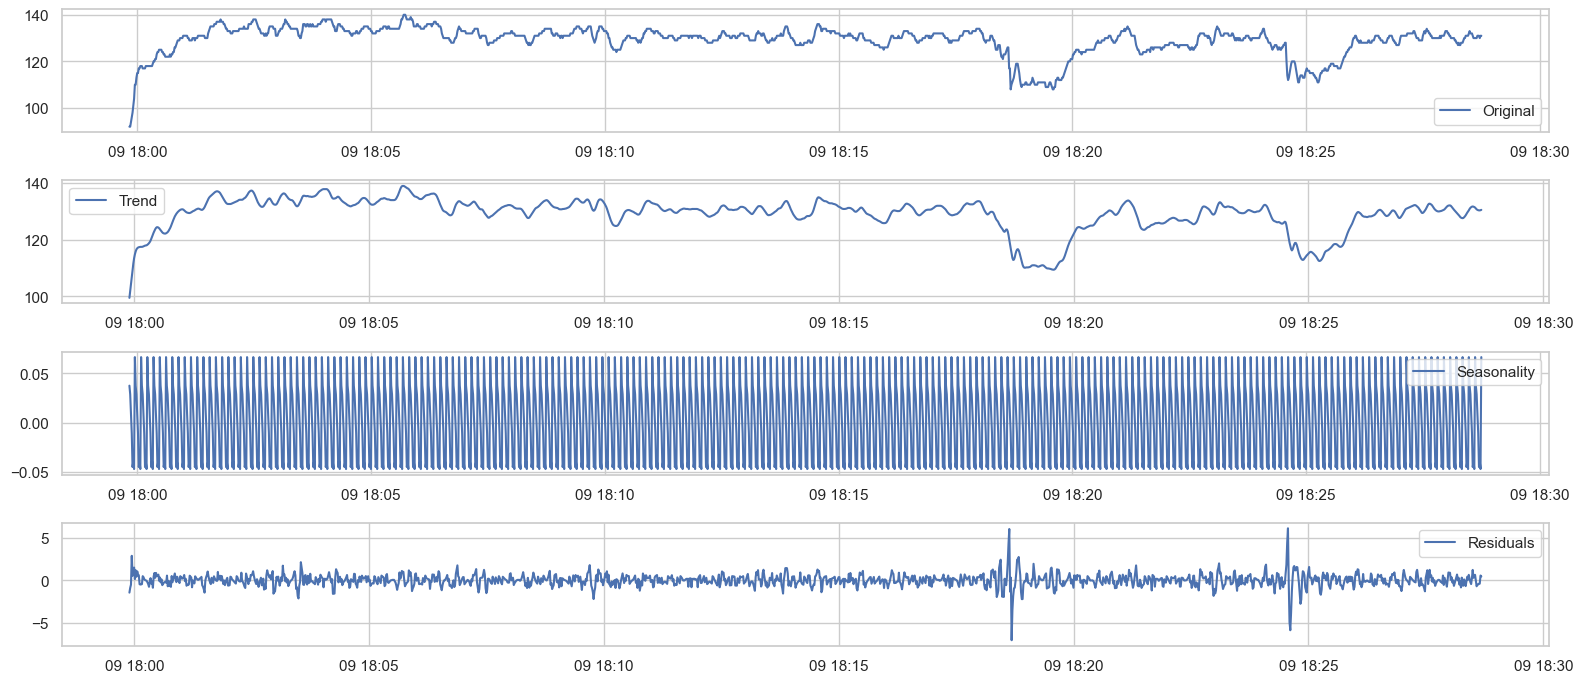

In [44]:
# Visualize the Original, Trend, Seasonality, and Residuals
plt.figure(figsize=(16, 7))
plt.subplot(411)
plt.plot(df["value"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Test Statistic                  -3.427865
p-value                          0.010045
#Lags Used                      15.000000
Numberof Observations Used    1720.000000
Critical Value (1%)             -3.434158
Critical Value (5%)             -2.863222
Critical Value (10%)            -2.567665
dtype: float64


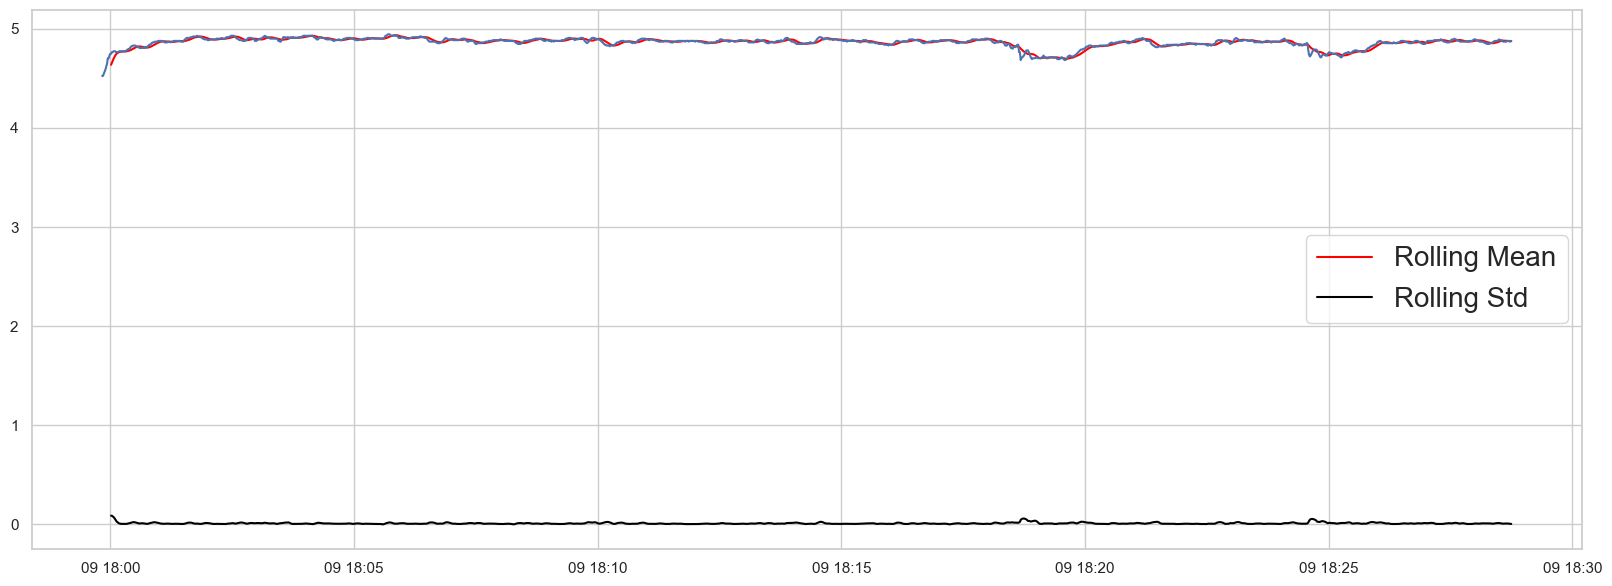

In [45]:
# Log Scale Transformation
log_df = np.log(df)
rolmean1 = log_df.rolling(window=12).mean()
rolstd1 = log_df.rolling(window=12).std()
stationarity_test(log_df)

Test Statistic               -8.610173e+00
p-value                       6.507985e-14
#Lags Used                    1.600000e+01
Numberof Observations Used    1.708000e+03
Critical Value (1%)          -3.434184e+00
Critical Value (5%)          -2.863234e+00
Critical Value (10%)         -2.567672e+00
dtype: float64


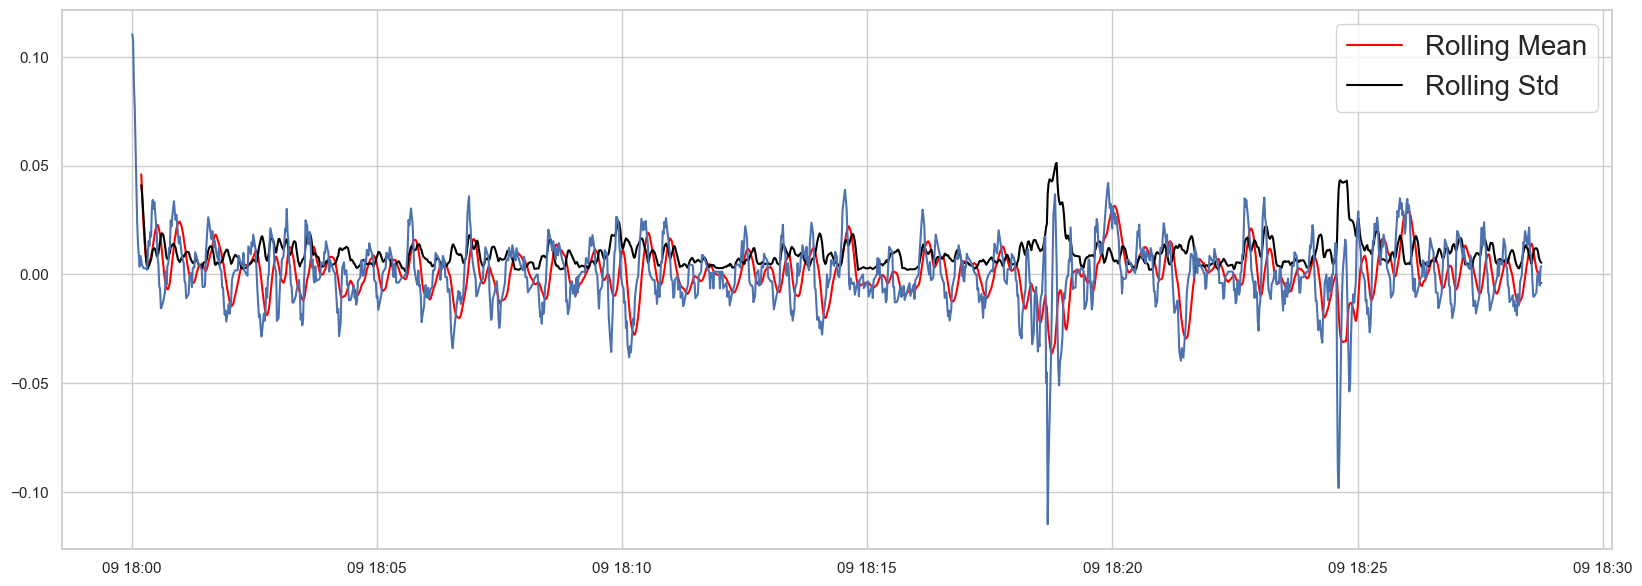

In [46]:
# Remove Trend
dataLogminusmean = log_df - rolmean1
# Remove NaN Values
dataLogminusmean.dropna(inplace=True)
stationarity_test(dataLogminusmean)

Test Statistic               -5.801674e+00
p-value                       4.615521e-07
#Lags Used                    1.600000e+01
Numberof Observations Used    1.719000e+03
Critical Value (1%)          -3.434160e+00
Critical Value (5%)          -2.863223e+00
Critical Value (10%)         -2.567666e+00
dtype: float64


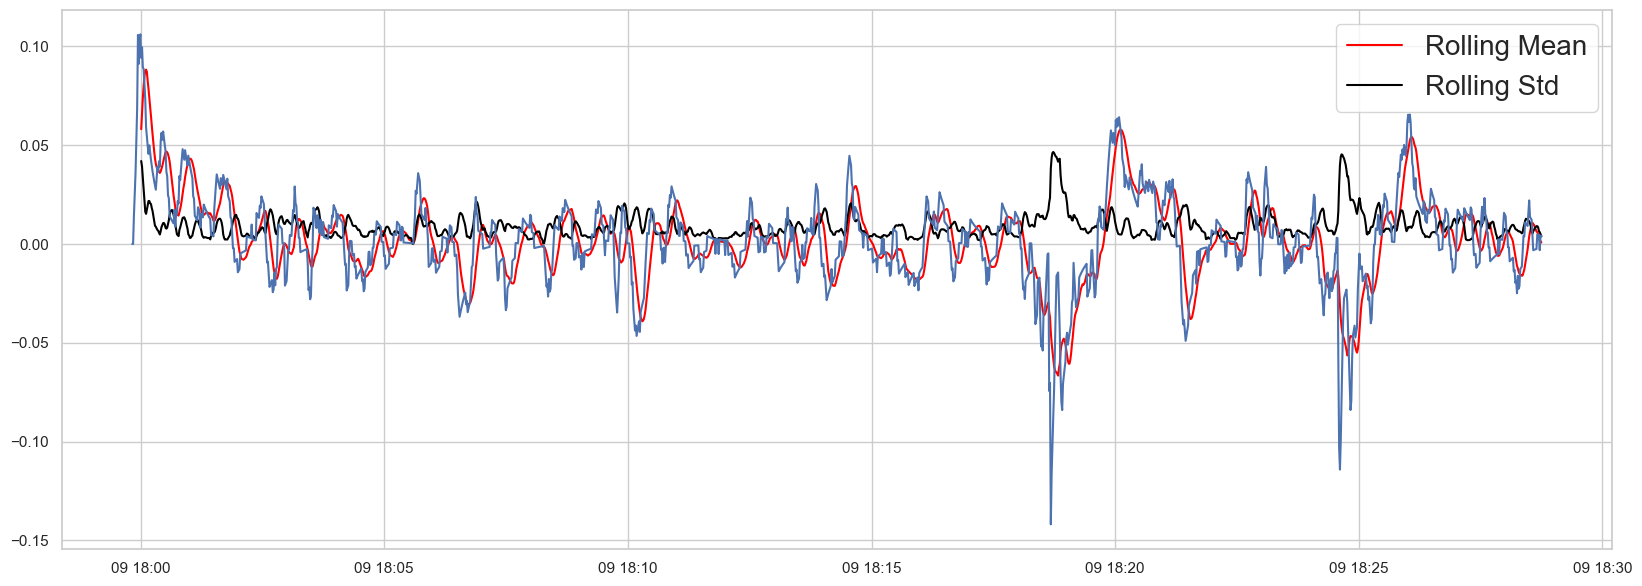

In [47]:
# Exponential Decay Transformation
exdecayweightedaverage = log_df.ewm(halflife=12, min_periods=0, adjust=True).mean()
index_logminusexdecay = log_df - exdecayweightedaverage
stationarity_test(index_logminusexdecay)

Test Statistic               -1.242726e+01
p-value                       4.013142e-23
#Lags Used                    1.500000e+01
Numberof Observations Used    1.719000e+03
Critical Value (1%)          -3.434160e+00
Critical Value (5%)          -2.863223e+00
Critical Value (10%)         -2.567666e+00
dtype: float64


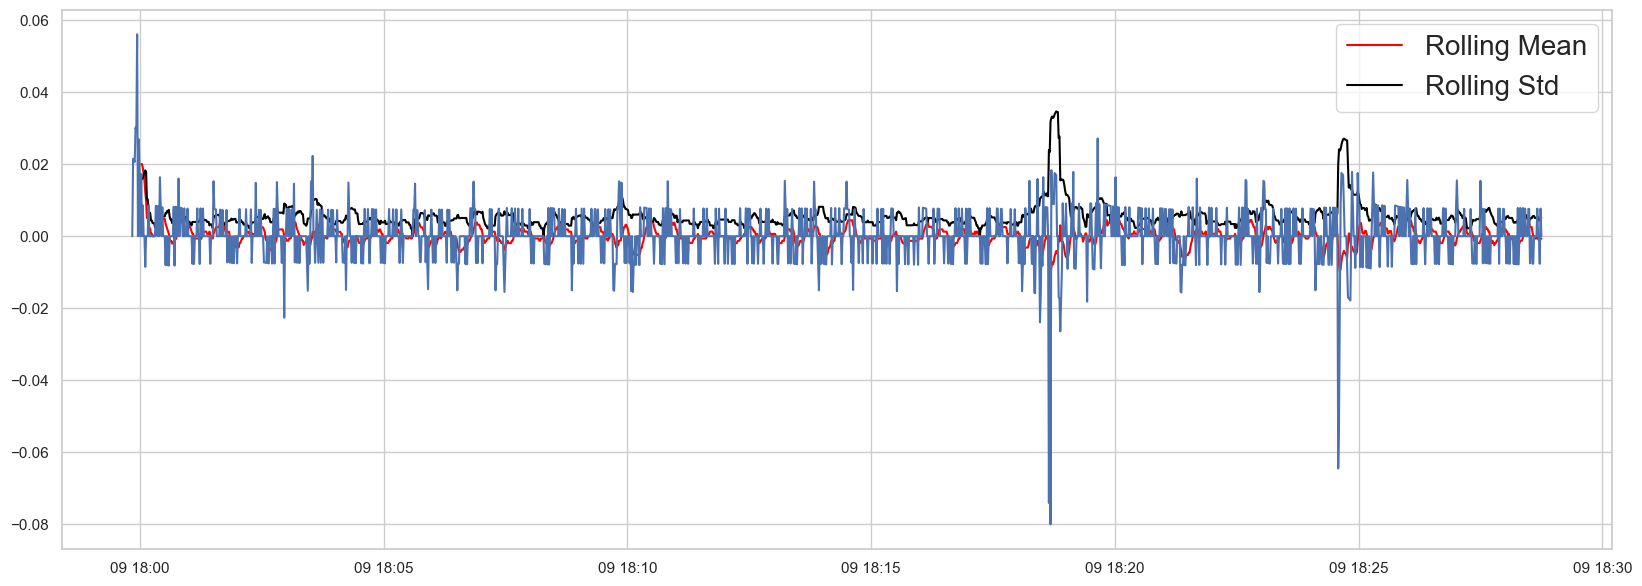

In [48]:
#Time Shift Transformation
diff_shift = log_df - log_df.shift()
diff_shift.dropna(inplace=True)
stationarity_test(diff_shift)

The log scale transformation (log_df) does best. The decomposition transformation was performed on the log scale transformation, however, did not show much of a difference. The log scale transformation has a Test statistic of -3.427865 and p-value of 0.010045. This transformation will be utilized going further. 

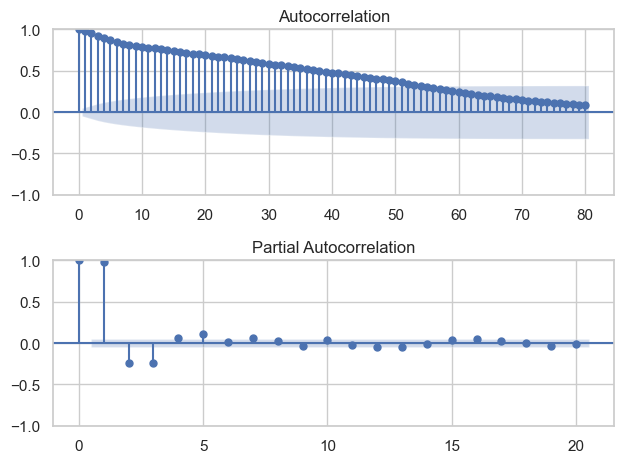

In [49]:
# Plotting ACF and PACF with lolliplot plots to identify order for future prediction models
# 
p, ax = plt.subplots(nrows=2, ncols=1)
plot_acf(log_df, lags=80, ax=ax[0])
plot_pacf(log_df, lags=20, ax=ax[1], method='ols')
plt.tight_layout()
plt.show()

## 5. Fitting Model 

RMSE:  2.296912216890605


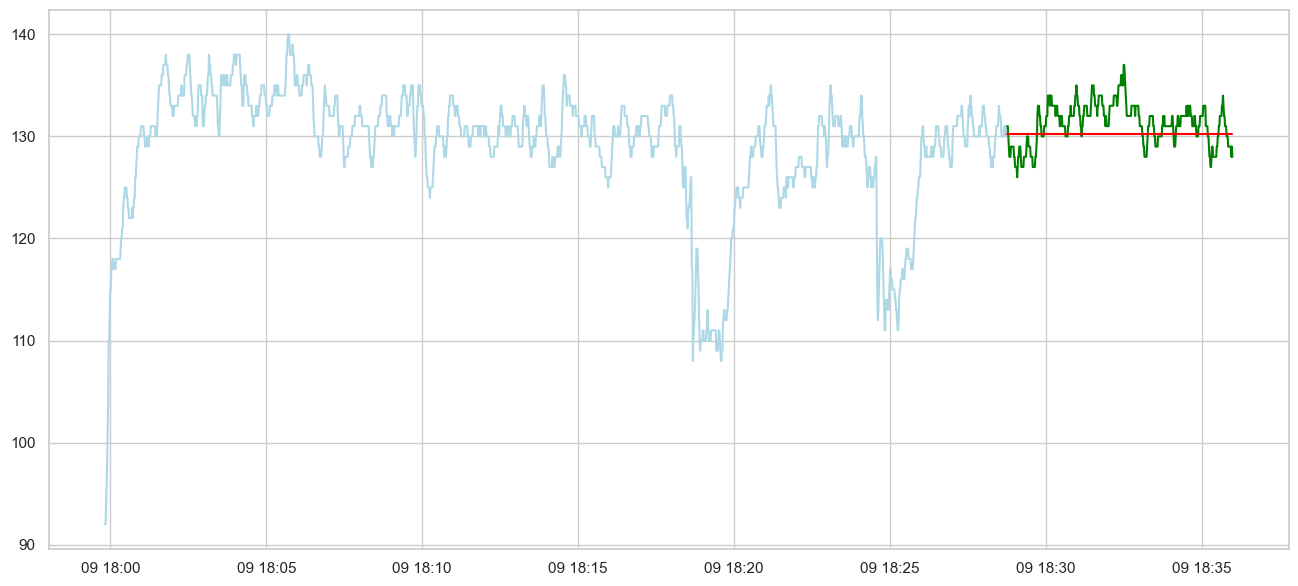

In [50]:
# Plotting AR Model
model = ARIMA(log_df, order=(2, 1, 0)) 
AR = model.fit()
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
# Predictions
prediction = pd.DataFrame(AR.forecast(len(x_test))[0], index=x_test.index, columns=["new_values"])
# Back to normal values
prediction["new_values"] = prediction["new_values"].apply(lambda x: math.exp(x)-1)
# Mean Squared Error
ms_2 = math.pow(mean_squared_error(x_test.values, prediction.values), 0.5)
print('RMSE: ',ms_2)
new_prediction = prediction.fillna(0).values
plt.plot(prediction.index, new_prediction, color="red")
plt.show()

RMSE:  2.238265771327244


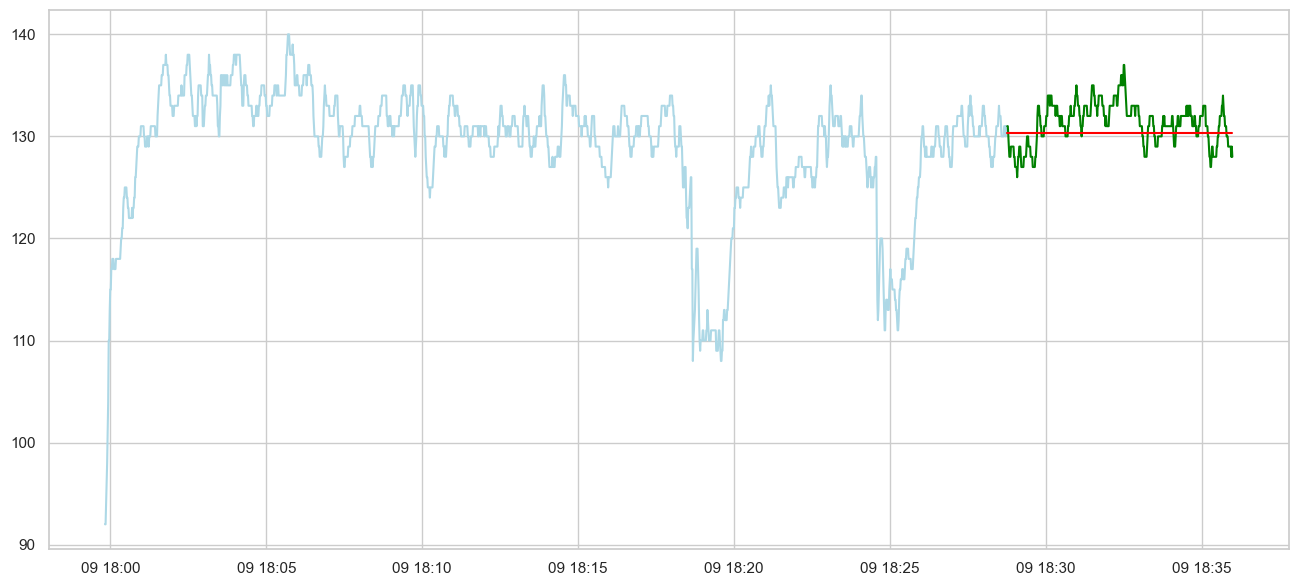

In [51]:
#Plotting MA Model 
model = ARIMA(log_df, order=(0, 1, 2))  
MA = model.fit()  
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
pred1 = pd.DataFrame(MA.forecast(len(x_test))[0], index=x_test.index, columns=["new_values"])
pred1.columns = ["new_values"]
pred1.index = x_test.index
pred1["new_values"] = pred1["new_values"].apply(lambda x: math.exp(x)-1)
measure = math.pow(mean_squared_error(x_test.values, pred1.values), 0.5)
print('RMSE: ',measure)
plt.plot(pred1.index, pred1.fillna(0).values, color="red")
plt.show()

                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                 1736
Model:                 ARIMA(2, 1, 2)   Log Likelihood                6284.634
Date:                Sat, 19 Oct 2024   AIC                         -12559.268
Time:                        14:40:15   BIC                         -12531.974
Sample:                    12-09-2021   HQIC                        -12549.174
                         - 12-09-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2898      0.065      4.477      0.000       0.163       0.417
ar.L2         -0.0951      0.060     -1.578      0.114      -0.213       0.023
ma.L1         -0.1140      0.066     -1.735      0.0

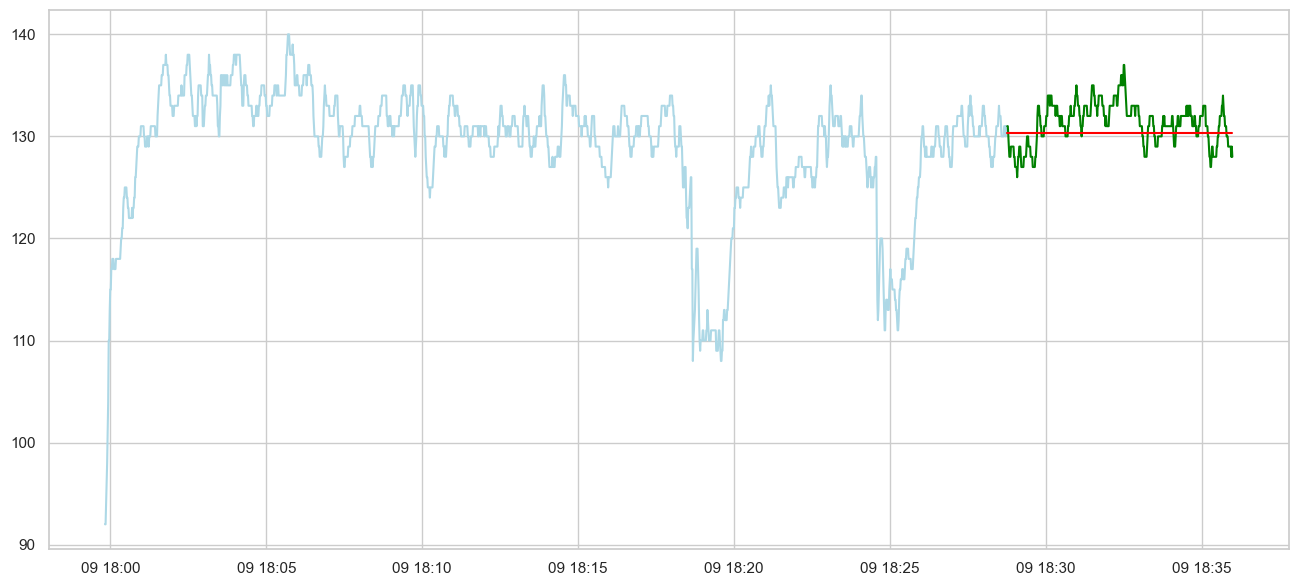

In [52]:
#Applying ARIMA Model 
model = ARIMA(log_df, order=(2, 1, 2))  
results_ARIMA = model.fit()
print(results_ARIMA.summary())
plt.figure(figsize=(16, 7))
plt.plot(x_train.index, x_train.values, color="lightblue")
plt.plot(x_test.index, x_test.values, color="green")
pred2 = pd.DataFrame(results_ARIMA.forecast(len(x_test))[0], index=x_test.index, columns=["new_values"])
pred2.columns = ["new_values"]
pred2.index = x_test.index
pred2["new_values"] = pred2["new_values"].apply(lambda x: math.exp(x)-1)
measure = math.pow(mean_squared_error(x_test.values, pred2.values), 0.5)
print('RMSE: ',measure)
plt.plot(pred2.index, pred2.fillna(0).values, color="red")
plt.show()

Conclusion:

AR Model does best with an RMSE of 2.2969. 